In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from math import sqrt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
data2 = pd.read_csv(r'data_set_2_cost_data_2012_2020.csv')
data2.shape

(108, 4)

In [5]:
data2.columns = [x.lower().replace(" ","_") for x in data2.columns]
data2.head()

,year,quarter,repair_type,observed_average_cost
0,2012,1,Exterior repair,22344.31
1,2012,1,Total replacement,42964.16
2,2012,1,Trailer repair,9348.70
3,2012,2,Exterior repair,23143.76
4,2012,2,Total replacement,39842.65


In [6]:
data2.repair_type.value_counts()

repair_type
Exterior repair      36
Total replacement    36
Trailer repair       36
Name: count, dtype: int64

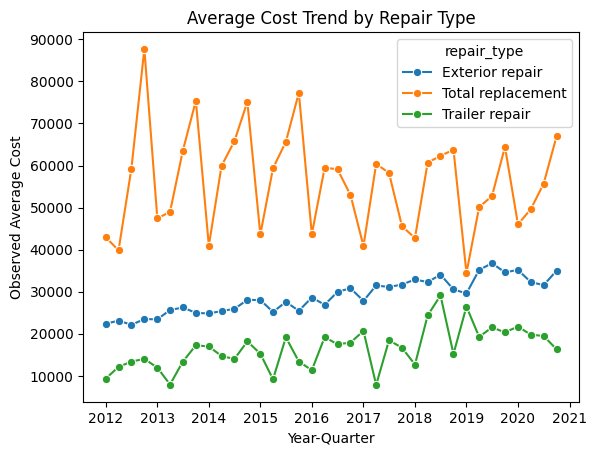

In [7]:
# data2[data2.repair_type=='Exterior repair']import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data2['date'] = pd.to_datetime(data2['year'].astype(str) + 'Q' + data2['quarter'].astype(str))
sns.lineplot(data=data2, x='date', y='observed_average_cost', hue='repair_type', marker='o')
plt.title('Average Cost Trend by Repair Type')
plt.ylabel('Observed Average Cost')
plt.xlabel('Year-Quarter')
plt.show()


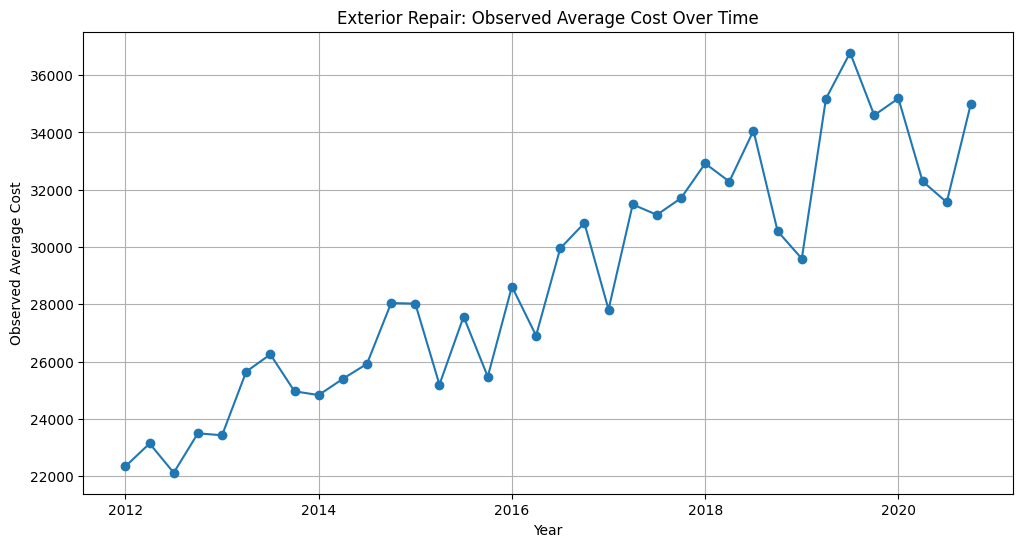

In [8]:
# Create a 'time' column combining year and quarter
data2['time'] = data2['year'] + (data2['quarter']-1)/4
# data2[['year','quarter','time']]
df = data2[data2.repair_type=='Exterior repair']

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['observed_average_cost'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Observed Average Cost')
plt.title('Exterior Repair: Observed Average Cost Over Time')
plt.grid(True)
plt.show()


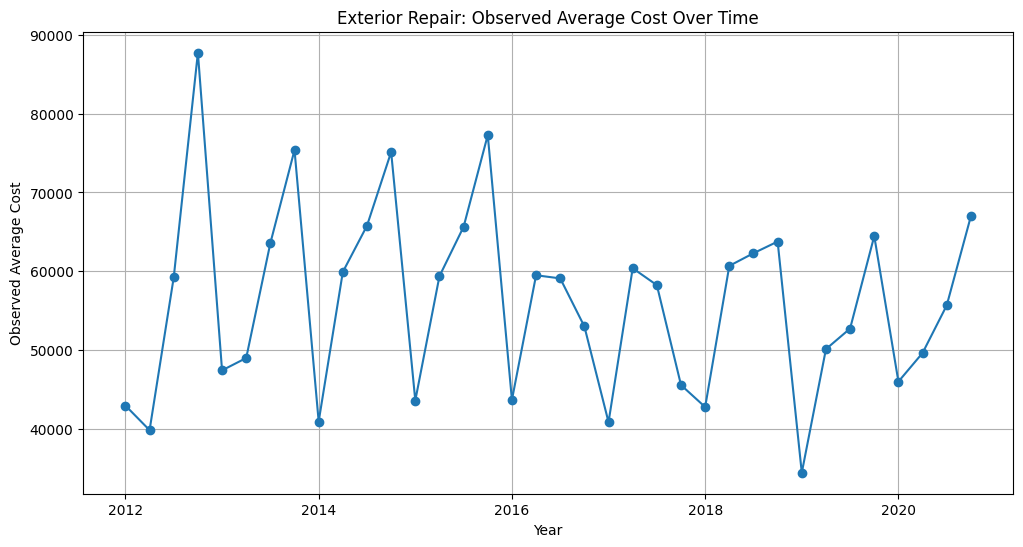

In [9]:
# Create a 'time' column combining year and quarter
data2['time'] = data2['year'] + (data2['quarter']-1)/4
# data2[['year','quarter','time']]
df = data2[data2.repair_type=='Total replacement']

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['observed_average_cost'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Observed Average Cost')
plt.title('Exterior Repair: Observed Average Cost Over Time')
plt.grid(True)
plt.show()


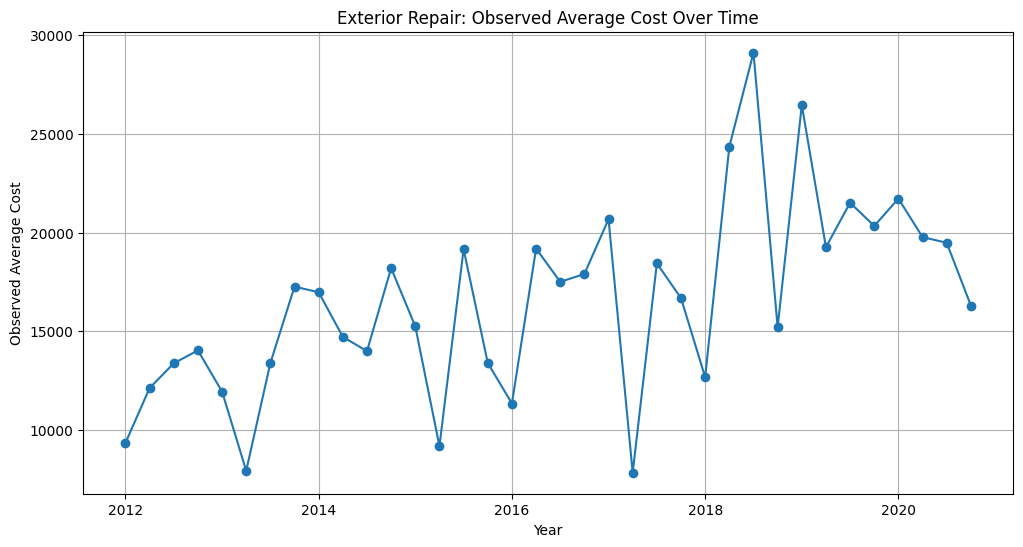

In [10]:
# Create a 'time' column combining year and quarter
data2['time'] = data2['year'] + (data2['quarter']-1)/4
# data2[['year','quarter','time']]
df = data2[data2.repair_type=='Trailer repair']

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['observed_average_cost'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Observed Average Cost')
plt.title('Exterior Repair: Observed Average Cost Over Time')
plt.grid(True)
plt.show()


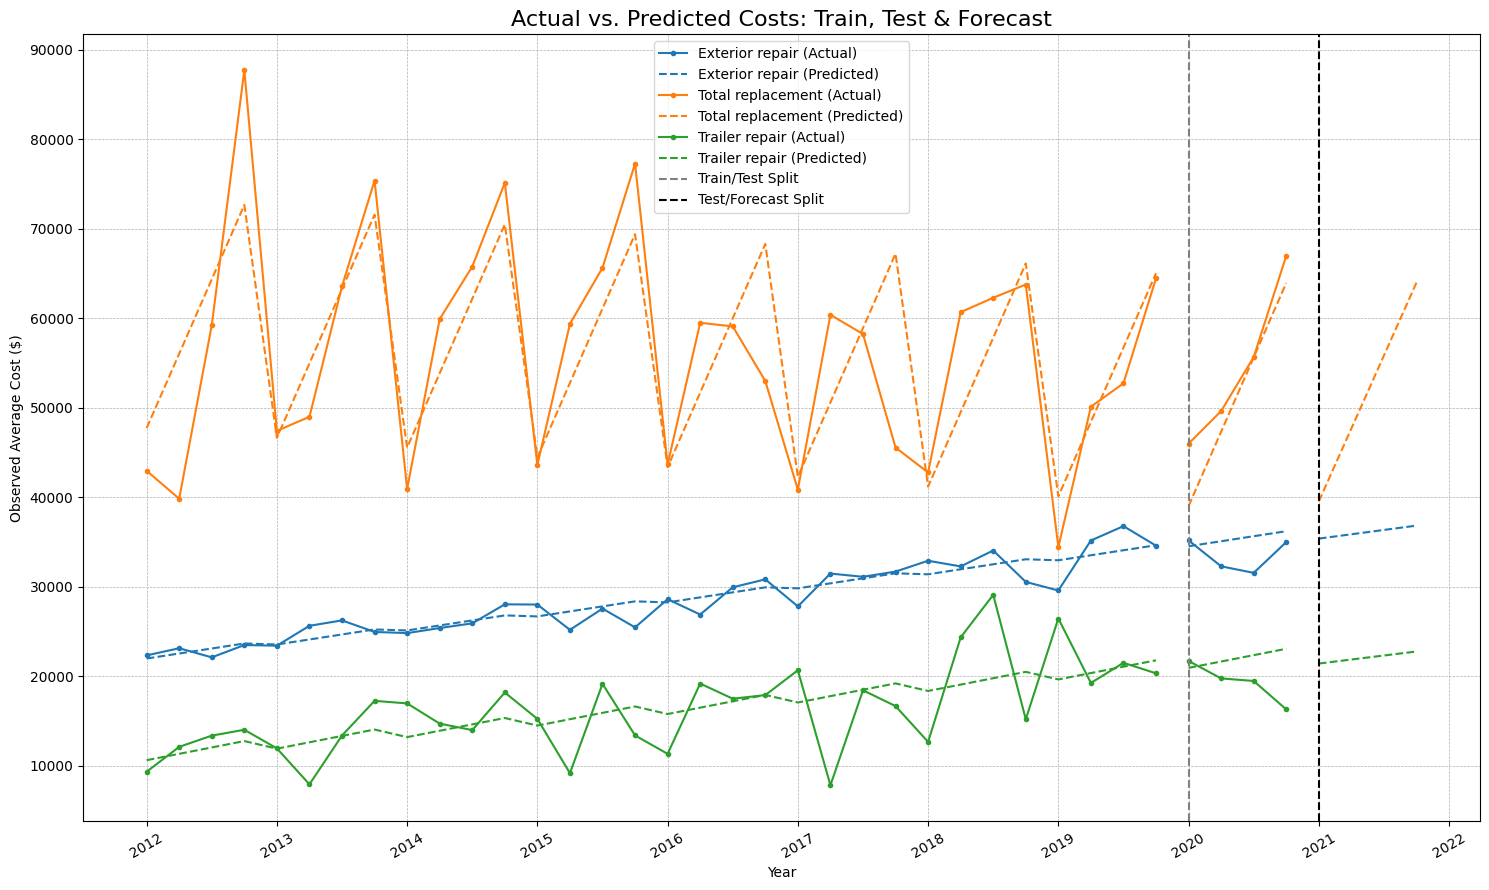

In [11]:
## Baseline LR model (ML approach):

np.random.seed(0) # For reproducibility

# --- Step 1: Split the Data ---
train_set = data2[data2['year'] < 2020].copy()
test_set = data2[data2['year'] == 2020].copy()


# --- Step 2: Initialize Plot ---
plt.figure(figsize=(15, 9))

# --- Step 3: Loop through, Model, Predict, and Plot ---
for repair_type in data2['repair_type'].unique():
    
    # --- a. Train the model on 2012-2019 data ---
    df_train = train_set[train_set['repair_type'] == repair_type]
    X_train = df_train[['year', 'quarter']]
    y_train = df_train['observed_average_cost']
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # --- b. Get predictions for all periods ---
    df_test = test_set[test_set['repair_type'] == repair_type]
    X_test = df_test[['year', 'quarter']]
    y_test_actual = df_test['observed_average_cost']
    
    # Get predictions on train and test sets from the initial model
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # --- c. Refit model on all data (2012-2020) for final forecast ---
    df_full_history = data2[(data2['year'] <= 2020) & (data2['repair_type'] == repair_type)]
    X_full = df_full_history[['year', 'quarter']]
    y_full = df_full_history['observed_average_cost']
    
    final_model = LinearRegression()
    final_model.fit(X_full, y_full)
    
    # Get 2021 forecast from the final, refitted model
    X_forecast_2021 = pd.DataFrame({'year': [2021]*4, 'quarter': [1, 2, 3, 4]})
    final_predictions_2021 = final_model.predict(X_forecast_2021)

    # --- d. Create time features for plotting ---
    time_train = X_train['year'] + (X_train['quarter'] - 1) / 4.0
    time_test = X_test['year'] + (X_test['quarter'] - 1) / 4.0
    time_forecast = X_forecast_2021['year'] + (X_forecast_2021['quarter'] - 1) / 4.0
    
    # --- e. Plot the data ---
    # Plot actuals (solid line) and get color
    line, = plt.plot(time_train, y_train, marker='.', linestyle='-', label=f'{repair_type} (Actual)')
    plt.plot(time_test, y_test_actual, marker='.', linestyle='-', color=line.get_color()) # Continue actuals line
    
    # Plot predictions (dashed line)
    plt.plot(time_train, train_predictions, linestyle='--', color=line.get_color(), label=f'{repair_type} (Predicted)')
    plt.plot(time_test, test_predictions, linestyle='--', color=line.get_color()) # Continue test predictions
    plt.plot(time_forecast, final_predictions_2021, linestyle='--', color=line.get_color()) # Add forecast line

# --- Step 4: Final Plot Formatting ---
plt.title('Actual vs. Predicted Costs: Train, Test & Forecast', fontsize=16)
plt.ylabel('Observed Average Cost ($)')
plt.xlabel('Year')
# Add vertical lines to distinguish between periods
plt.axvline(x=2020, color='grey', linestyle='--', label='Train/Test Split')
plt.axvline(x=2021, color='black', linestyle='--', label='Test/Forecast Split')
plt.xticks(np.arange(2012, 2023, 1), rotation=30)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout() # Adjust layout to make room for labels
plt.show()

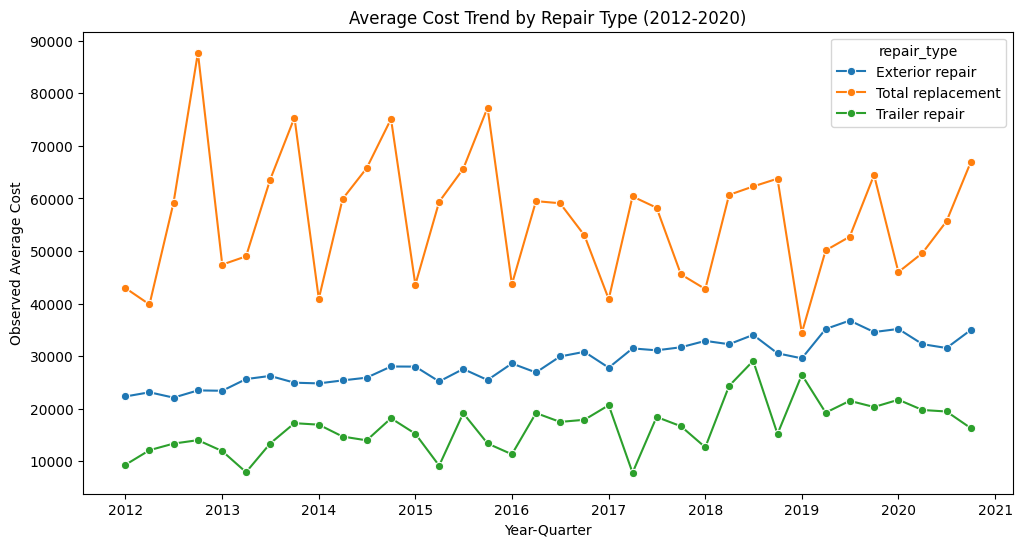

Quarterly Averages by Repair Type:
 quarter                       1             2             3             4
repair_type                                                              
Exterior repair    28086.111111  28616.053333  29483.755556  29409.222222
Total replacement  42521.470000  54273.537778  60250.868889  67700.674444
Trailer repair     16270.038889  14934.513333  18444.897778  16595.508889

Forecast for Exterior repair (2021 quarterly):
2021-01-01    35303.390876
2021-04-01    35833.226981
2021-07-01    36700.810401
2021-10-01    36626.173620
Freq: QS-OCT, dtype: float64

Forecast for Total replacement (2021 quarterly):
2021-01-01    40423.476945
2021-04-01    51388.186971
2021-07-01    55163.217283
2021-10-01    59795.306208
Freq: QS-OCT, dtype: float64

Forecast for Trailer repair (2021 quarterly):
2021-01-01    21688.521713
2021-04-01    20347.368638
2021-07-01    23844.174711
2021-10-01    22037.442565
Freq: QS-OCT, dtype: float64

Linear Regression Forecast for Exteri

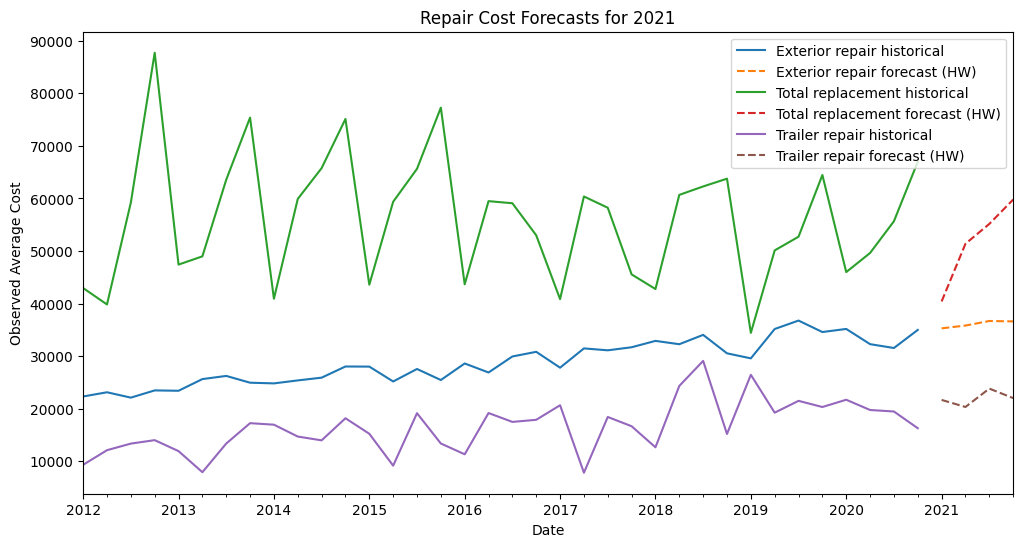

In [12]:
# Create a datetime column for plotting and modeling
data2['date'] = pd.to_datetime(data2['year'].astype(str) + 'Q' + data2['quarter'].astype(str))

# ---------------------------
# Exploratory Data Analysis
# ---------------------------

# Lineplot of cost trends
plt.figure(figsize=(12,6))
sns.lineplot(data=data2, x='date', y='observed_average_cost', hue='repair_type', marker='o')
plt.title('Average Cost Trend by Repair Type (2012-2020)')
plt.ylabel('Observed Average Cost')
plt.xlabel('Year-Quarter')
plt.show()

# Check quarterly averages to identify seasonality
seasonality_table = data2.groupby(['repair_type','quarter'])['observed_average_cost'].mean().unstack()
print("Quarterly Averages by Repair Type:\n", seasonality_table)

# ---------------------------
# Forecasting using Holt-Winters
# ---------------------------
forecast_results_hw = {}

for repair in data2['repair_type'].unique():
    df = data2[data2['repair_type']==repair].sort_values('date')
    ts = df.set_index('date')['observed_average_cost']
    
    # Holt-Winters model with additive trend and seasonality
    model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=4)
    fit = model.fit()
    
    # Forecast next 4 quarters (2021)
    forecast = fit.forecast(4)
    forecast_results_hw[repair] = forecast

# Display forecasts
for repair, forecast in forecast_results_hw.items():
    print(f"\nForecast for {repair} (2021 quarterly):")
    print(forecast)

# ---------------------------
# Linear Regression Forecast
# ---------------------------
forecast_results_lr = {}
for repair in data2['repair_type'].unique():
    df = data2[data2['repair_type']==repair].sort_values('date')
    X = np.arange(len(df)).reshape(-1,1)
    y = df['observed_average_cost'].values
    model = LinearRegression().fit(X, y)
    
    X_future = np.arange(len(df), len(df)+4).reshape(-1,1)
    forecast_results_lr[repair] = model.predict(X_future)

# Display linear regression forecasts
for repair, forecast in forecast_results_lr.items():
    print(f"\nLinear Regression Forecast for {repair} (2021 quarterly):")
    print(forecast)

# ---------------------------
# Visualization of forecasts
# ---------------------------
plt.figure(figsize=(12,6))
for repair, forecast in forecast_results_hw.items():
    ts = data2[data2['repair_type']==repair].sort_values('date').set_index('date')['observed_average_cost']
    ts.plot(label=f'{repair} historical')
    forecast.plot(label=f'{repair} forecast (HW)', linestyle='--')
plt.legend()
plt.title('Repair Cost Forecasts for 2021')
plt.ylabel('Observed Average Cost')
plt.xlabel('Date')
plt.show()

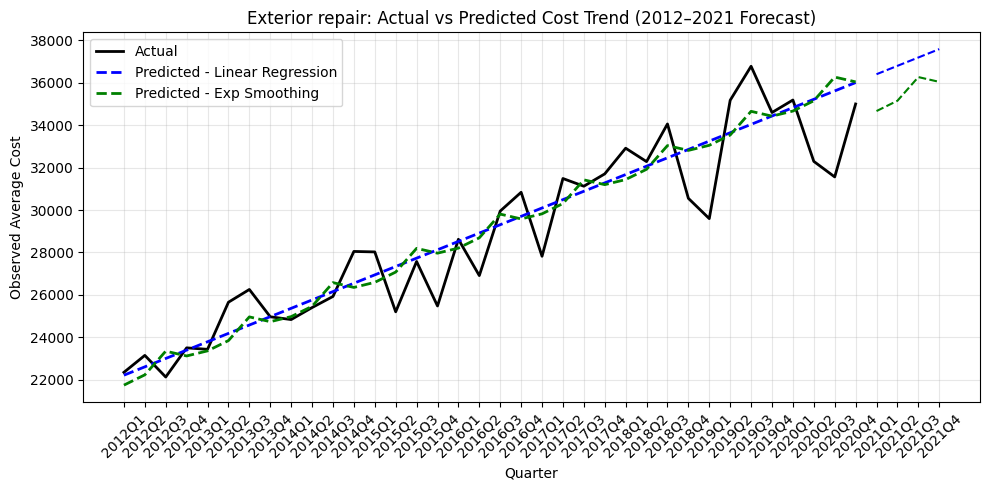

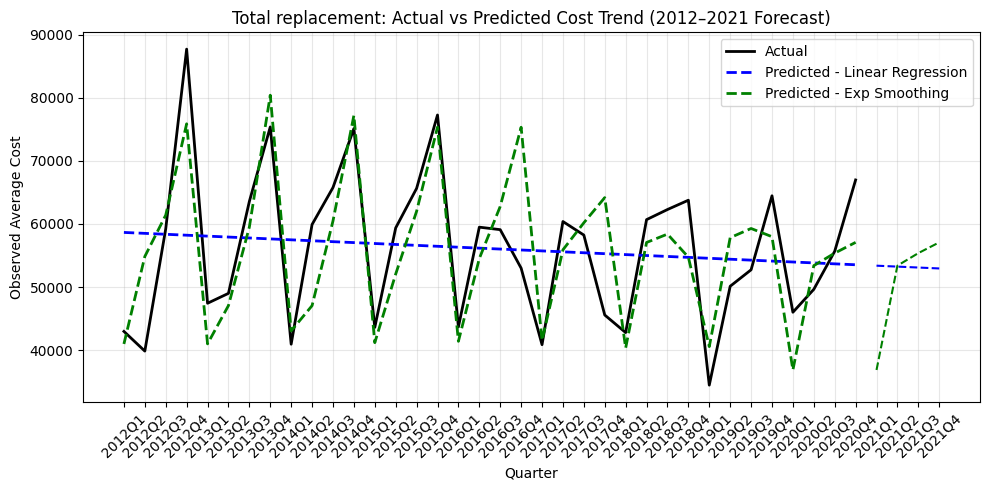

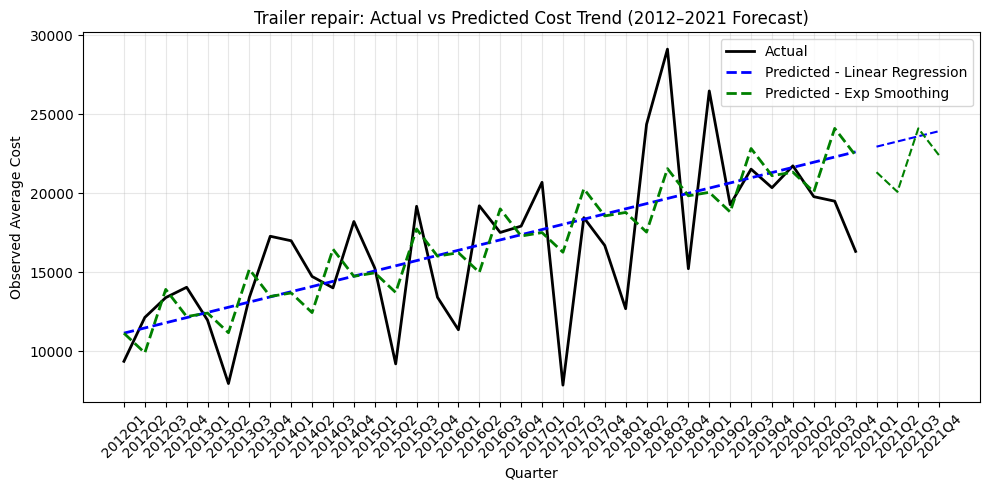

==== Quarterly-level Average Errors by Repair Type ====
         repair_type    MAPE_LR    MAPE_ES
0    Exterior repair   4.121184   4.277558
1  Total replacement  18.463947  11.089337
2     Trailer repair  20.763615  20.495631


In [13]:
data2['year_quarter'] = data2['year'].astype(str) + 'Q' + data2['quarter'].astype(str)
data2 = data2.sort_values(['repair_type', 'year', 'quarter']).reset_index(drop=True)

# Helper: metrics function
def compute_metrics(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# Function to run both models
def run_models(df, repair_type):
    df = df[df['repair_type'] == repair_type].copy().reset_index(drop=True)
    
    # Linear Regression -------------------------------------
    df['time_index'] = np.arange(1, len(df) + 1)
    X = df[['time_index']]
    y = df['observed_average_cost']

    # Train-test split (train till 2019)
    train_df = df[df['year'] < 2020]
    test_df = df[df['year'] == 2020]
    
    X_train, y_train = train_df[['time_index']], train_df['observed_average_cost']
    X_test, y_test = test_df[['time_index']], test_df['observed_average_cost']

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    df['pred_lr'] = lr.predict(X)

    # Forecast 2021
    future_idx = np.arange(df['time_index'].max() + 1, df['time_index'].max() + 5)
    future_lr_pred = lr.predict(future_idx.reshape(-1,1))
    future_lr = pd.DataFrame({
        'year': 2021,
        'quarter': [1,2,3,4],
        'pred_lr': future_lr_pred
    })
    
    # Exponential Smoothing -------------------------------------
    es_model = ExponentialSmoothing(train_df['observed_average_cost'],
                                    trend='add', seasonal='add', seasonal_periods=4).fit()
    df['pred_es'] = es_model.predict(start=0, end=len(df)-1)
    
    # Forecast next 4 quarters (2021)
    future_es_pred = es_model.forecast(4)
    future_es = pd.DataFrame({
        'year': 2021,
        'quarter': [1,2,3,4],
        'pred_es': future_es_pred.values
    })
    
    # Combine future predictions
    future_combined = pd.DataFrame({
        'year': [2021]*4,
        'quarter': [1,2,3,4],
        'repair_type': repair_type,
        'pred_lr': future_lr['pred_lr'],
        'pred_es': future_es['pred_es']
    })
    
    # --- Quarterly metrics (per quarter) ---
    metrics_df = (
        df.groupby(['year', 'quarter', 'year_quarter'])
        .apply(lambda g: pd.Series({
            'repair_type': repair_type,
            'RMSE_LR': sqrt(mean_squared_error(g['observed_average_cost'], g['pred_lr'])),
            'MAE_LR': mean_absolute_error(g['observed_average_cost'], g['pred_lr']),
            'MAPE_LR': np.mean(np.abs((g['observed_average_cost'] - g['pred_lr']) / g['observed_average_cost'])) * 100,
            'RMSE_ES': sqrt(mean_squared_error(g['observed_average_cost'], g['pred_es'])),
            'MAE_ES': mean_absolute_error(g['observed_average_cost'], g['pred_es']),
            'MAPE_ES': np.mean(np.abs((g['observed_average_cost'] - g['pred_es']) / g['observed_average_cost'])) * 100
        }))
        .reset_index()
    )

    # Plotting -------------------------------------
    plt.figure(figsize=(10,5))
    plt.plot(df['year_quarter'], df['observed_average_cost'], label='Actual', color='black', linewidth=2)
    plt.plot(df['year_quarter'], df['pred_lr'], label='Predicted - Linear Regression', color='blue', linestyle='--', linewidth=2)
    plt.plot(df['year_quarter'], df['pred_es'], label='Predicted - Exp Smoothing', color='green', linestyle='--', linewidth=2)
    
    # Add 2021 forecast (dashed continuation)
    plt.plot([f"2021Q{i}" for i in [1,2,3,4]], future_lr['pred_lr'], color='blue', linestyle='--')
    plt.plot([f"2021Q{i}" for i in [1,2,3,4]], future_es['pred_es'], color='green', linestyle='--')
    
    plt.title(f"{repair_type}: Actual vs Predicted Cost Trend (2012–2021 Forecast)")
    plt.xlabel("Quarter")
    plt.ylabel("Observed Average Cost")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return metrics_df, future_combined

# Run for all 3 repair types
all_metrics = []
all_forecasts = []

for rep in ['Exterior repair', 'Total replacement', 'Trailer repair']:
    m, f = run_models(data2, rep)
    all_metrics.append(m)
    all_forecasts.append(f)

metrics_all = pd.concat(all_metrics)
forecast_all = pd.concat(all_forecasts)

# Aggregate summary by model
agg_metrics = metrics_all.groupby('repair_type')[['MAPE_LR','MAPE_ES']].mean().reset_index()
print("==== Quarterly-level Average Errors by Repair Type ====")
print(agg_metrics)

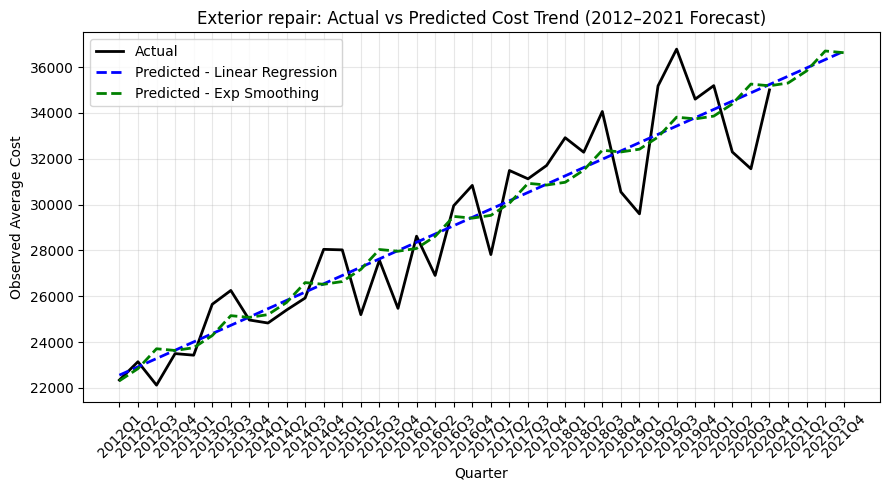

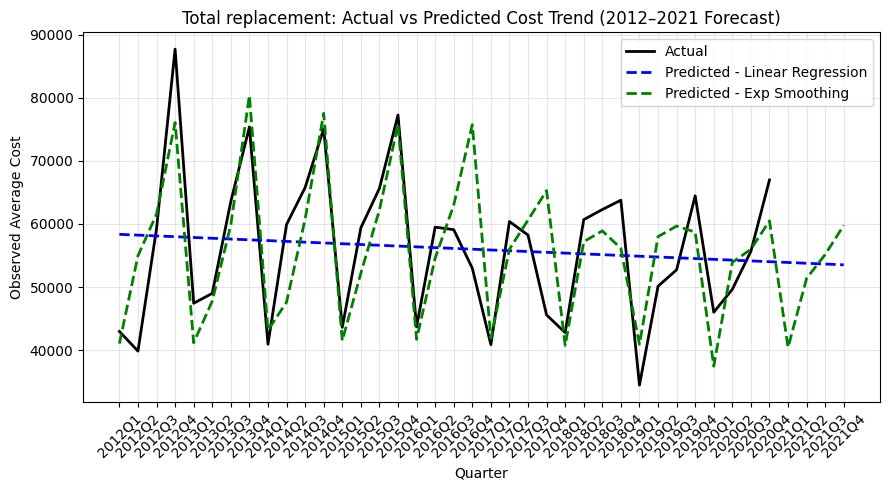

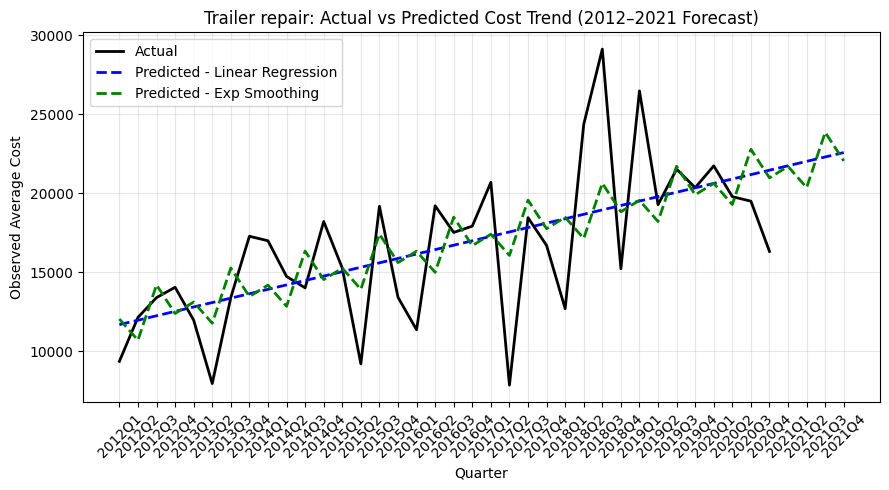

==== Quarterly Metrics (2012–2021) ====


,repair_type,year,quarter,year_quarter,Actual,Pred_LR,Pred_ES,RMSE_LR,MAE_LR,MAPE_LR,RMSE_ES,MAE_ES,MAPE_ES
0,Exterior repair,2012,1,2012Q1,22344.31,22559.014835,22312.531984,214.704835,214.704835,0.960893,31.778016,31.778016,0.142220
1,Exterior repair,2012,2,2012Q2,23143.76,22921.287447,22842.368089,222.472553,222.472553,0.961264,301.391911,301.391911,1.302260
2,Exterior repair,2012,3,2012Q3,22123.28,23283.560060,23709.951514,1160.280060,1160.280060,5.244611,1586.671514,1586.671514,7.171954
3,Exterior repair,2012,4,2012Q4,23498.98,23645.832673,23635.314709,146.852673,146.852673,0.624932,136.334709,136.334709,0.580173
4,Exterior repair,2013,1,2013Q1,23430.05,24008.105285,23755.960729,578.055285,578.055285,2.467153,325.910729,325.910729,1.390995


In [14]:
# --- Helper metric function ---
def compute_metrics(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan
    return rmse, mae, mape


# --- Load and prepare data ---
data2 = pd.read_csv('data_set_2_cost_data_2012_2020.csv')
data2.columns = [x.lower().replace(" ", "_") for x in data2.columns]
data2['year_quarter'] = data2['year'].astype(str) + 'Q' + data2['quarter'].astype(str)
data2 = data2.sort_values(['repair_type', 'year', 'quarter']).reset_index(drop=True)


# --- Core function for each repair type ---
def run_models_all_years(df, repair_type):
    df = df[df['repair_type'] == repair_type].copy().reset_index(drop=True)
    df['time_index'] = np.arange(1, len(df) + 1)

    # 1️⃣ Linear Regression
    lr = LinearRegression()
    lr.fit(df[['time_index']], df['observed_average_cost'])
    df['pred_lr'] = lr.predict(df[['time_index']])

    # 2️⃣ Exponential Smoothing
    es = ExponentialSmoothing(df['observed_average_cost'],
                              trend='add', seasonal='add', seasonal_periods=4).fit()
    df['pred_es'] = es.predict(start=0, end=len(df)-1)

    # 3️⃣ Forecast 2021 (no actuals)
    future_idx = np.arange(df['time_index'].max() + 1, df['time_index'].max() + 5)
    forecast_lr = lr.predict(future_idx.reshape(-1, 1))
    forecast_es = es.forecast(4)

    df_forecast = pd.DataFrame({
        'year': [2021]*4,
        'quarter': [1,2,3,4],
        'repair_type': repair_type,
        'pred_lr': forecast_lr,
        'pred_es': forecast_es
    })
    df_forecast['year_quarter'] = df_forecast['year'].astype(str) + 'Q' + df_forecast['quarter'].astype(str)
    df_forecast['observed_average_cost'] = np.nan  # no actuals for 2021

    # Combine all (2012–2021)
    df_all = pd.concat([df, df_forecast], ignore_index=True)

    # --- Compute metrics for years where actuals exist ---
    df_all_metrics = []
    for (y, q), g in df_all.groupby(['year', 'quarter']):
        if g['observed_average_cost'].notna().all():
            rmse_lr, mae_lr, mape_lr = compute_metrics(g['observed_average_cost'], g['pred_lr'])
            rmse_es, mae_es, mape_es = compute_metrics(g['observed_average_cost'], g['pred_es'])
        else:
            rmse_lr = mae_lr = mape_lr = rmse_es = mae_es = mape_es = np.nan
        df_all_metrics.append({
            'repair_type': repair_type,
            'year': y,
            'quarter': q,
            'year_quarter': f"{y}Q{q}",
            'Actual': g['observed_average_cost'].mean(),
            'Pred_LR': g['pred_lr'].mean(),
            'Pred_ES': g['pred_es'].mean(),
            'RMSE_LR': rmse_lr,
            'MAE_LR': mae_lr,
            'MAPE_LR': mape_lr,
            'RMSE_ES': rmse_es,
            'MAE_ES': mae_es,
            'MAPE_ES': mape_es
        })

    df_all_metrics = pd.DataFrame(df_all_metrics)

    # --- Plotting ---
    plt.figure(figsize=(9, 5))
    plt.plot(df_all['year_quarter'], df_all['observed_average_cost'], color='black', label='Actual', linewidth=2)
    plt.plot(df_all['year_quarter'], df_all['pred_lr'], '--', color='blue', label='Predicted - Linear Regression', linewidth=2)
    plt.plot(df_all['year_quarter'], df_all['pred_es'], '--', color='green', label='Predicted - Exp Smoothing', linewidth=2)
    plt.title(f"{repair_type}: Actual vs Predicted Cost Trend (2012–2021 Forecast)")
    plt.xlabel("Quarter")
    plt.ylabel("Observed Average Cost")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_all_metrics


# --- Run for all three repair types ---
all_metrics = []
for rep in ['Exterior repair', 'Total replacement', 'Trailer repair']:
    m = run_models_all_years(data2, rep)
    all_metrics.append(m)

metrics_all = pd.concat(all_metrics).reset_index(drop=True)

# --- Output ---
print("==== Quarterly Metrics (2012–2021) ====")
metrics_all.head()

In [15]:
def run_models_all_years(df, repair_type):
    df = df[df['repair_type'] == repair_type].copy().reset_index(drop=True)
    df['time_index'] = np.arange(1, len(df) + 1)

    # 1️⃣ Linear Regression
    lr = LinearRegression()
    lr.fit(df[['time_index']], df['observed_average_cost'])
    df['pred_lr'] = lr.predict(df[['time_index']])

    # 2️⃣ Exponential Smoothing
    es = ExponentialSmoothing(df['observed_average_cost'],
                              trend='add', seasonal='add', seasonal_periods=4).fit()
    df['pred_es'] = es.predict(start=0, end=len(df)-1)

    # 3️⃣ Forecast 2021 (no actuals)
    future_idx = np.arange(df['time_index'].max() + 1, df['time_index'].max() + 5)
    forecast_lr = lr.predict(future_idx.reshape(-1, 1))
    forecast_es = es.forecast(4)

    df_forecast = pd.DataFrame({
        'year': [2021]*4,
        'quarter': [1,2,3,4],
        'repair_type': repair_type,
        'pred_lr': forecast_lr,
        'pred_es': forecast_es
    })
    df_forecast['year_quarter'] = df_forecast['year'].astype(str) + 'Q' + df_forecast['quarter'].astype(str)
    df_forecast['observed_average_cost'] = np.nan  # no actuals for 2021

    # Combine all (2012–2021)
    df_all = pd.concat([df, df_forecast], ignore_index=True)

    # --- Compute metrics for years where actuals exist ---
    df_all_metrics = []
    for (y, q), g in df_all.groupby(['year', 'quarter']):
        if g['observed_average_cost'].notna().all():
            rmse_lr, mae_lr, mape_lr = compute_metrics(g['observed_average_cost'], g['pred_lr'])
            rmse_es, mae_es, mape_es = compute_metrics(g['observed_average_cost'], g['pred_es'])
        else:
            rmse_lr = mae_lr = mape_lr = rmse_es = mae_es = mape_es = np.nan
        df_all_metrics.append({
            'repair_type': repair_type,
            'year': y,
            'quarter': q,
            'year_quarter': f"{y}Q{q}",
            'Actual': g['observed_average_cost'].mean(),
            'Pred_LR': g['pred_lr'].mean(),
            'Pred_ES': g['pred_es'].mean(),
            'RMSE_LR': rmse_lr,
            'MAE_LR': mae_lr,
            'MAPE_LR': mape_lr,
            'RMSE_ES': rmse_es,
            'MAE_ES': mae_es,
            'MAPE_ES': mape_es
        })

    df_all_metrics = pd.DataFrame(df_all_metrics)

    # 🔹 NEW: Add yearly (combined) values for 2021
    df_2021 = df_forecast.copy()
    df_2021_combined = pd.DataFrame({
        'repair_type': [repair_type],
        'year': [2021],
        'quarter': ['All'],
        'year_quarter': ['2021_All'],
        'Actual': [np.nan],
        'Pred_LR': [df_2021['pred_lr'].mean()],
        'Pred_ES': [df_2021['pred_es'].mean()],
        'RMSE_LR': [np.nan],
        'MAE_LR': [np.nan],
        'MAPE_LR': [np.nan],
        'RMSE_ES': [np.nan],
        'MAE_ES': [np.nan],
        'MAPE_ES': [np.nan]
    })

    df_all_metrics = pd.concat([df_all_metrics, df_2021_combined], ignore_index=True)

    # --- Plotting ---
    plt.figure(figsize=(9, 5))
    plt.plot(df_all['year_quarter'], df_all['observed_average_cost'], color='black', label='Actual', linewidth=2)
    plt.plot(df_all['year_quarter'], df_all['pred_lr'], '--', color='blue', label='Predicted - Linear Regression', linewidth=2)
    plt.plot(df_all['year_quarter'], df_all['pred_es'], '--', color='green', label='Predicted - Exp Smoothing', linewidth=2)
    plt.title(f"{repair_type}: Actual vs Predicted Cost Trend (2012–2021 Forecast)")
    plt.xlabel("Quarter")
    plt.ylabel("Observed Average Cost")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_all_metrics


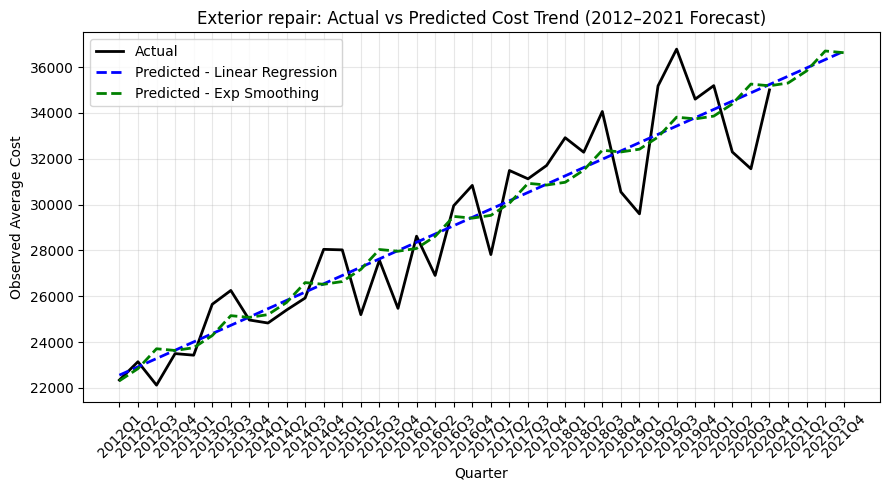

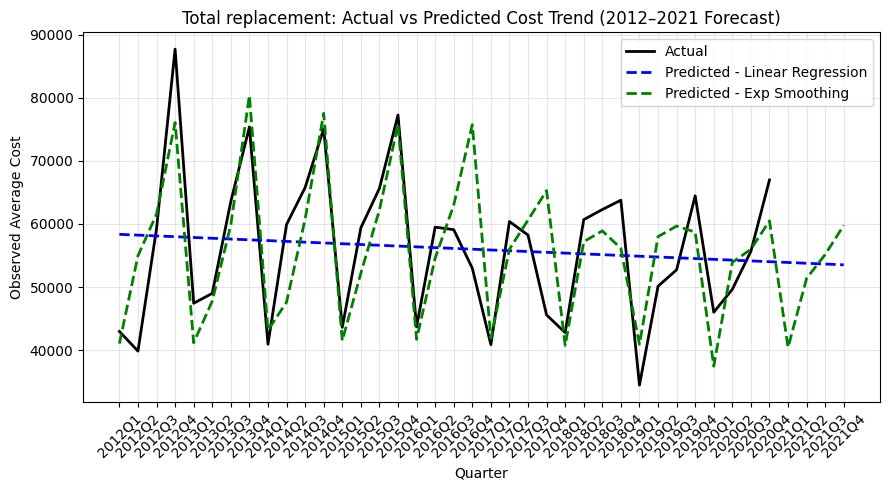

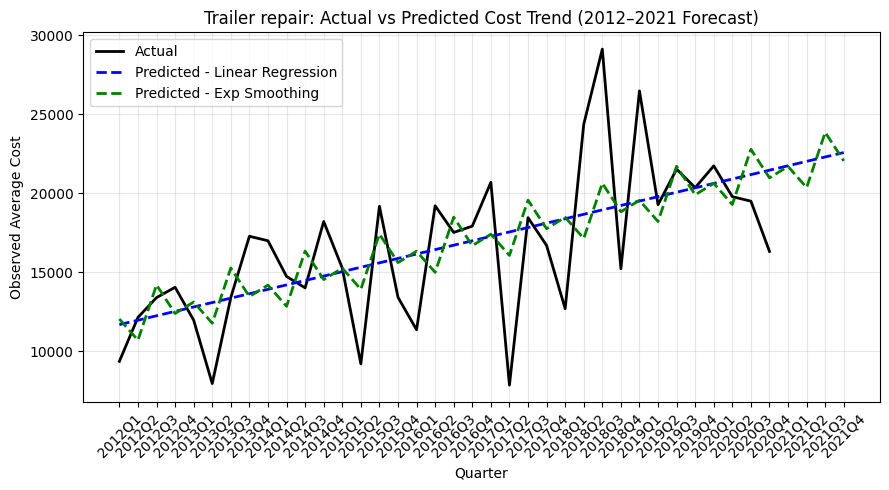

==== Quarterly + 2021 Combined Metrics ====
        repair_type  year quarter year_quarter    Actual       Pred_LR  \
113  Trailer repair  2019       4       2019Q4  20340.81  20331.841967   
114  Trailer repair  2020       1       2020Q1  21723.23  20611.145837   
115  Trailer repair  2020       2       2020Q2  19773.22  20890.449707   
116  Trailer repair  2020       3       2020Q3  19486.95  21169.753577   
117  Trailer repair  2020       4       2020Q4  16308.06  21449.057447   
118  Trailer repair  2021       1       2021Q1       NaN  21728.361317   
119  Trailer repair  2021       2       2021Q2       NaN  22007.665187   
120  Trailer repair  2021       3       2021Q3       NaN  22286.969057   
121  Trailer repair  2021       4       2021Q4       NaN  22566.272927   
122  Trailer repair  2021     All     2021_All       NaN  22147.317122   

          Pred_ES      RMSE_LR       MAE_LR    MAPE_LR      RMSE_ES  \
113  19890.650027     8.968033     8.968033   0.044089   450.159973   

In [16]:
# --- Step 1: Run the function for each repair type ---
all_metrics = []
for rep in ['Exterior repair', 'Total replacement', 'Trailer repair']:
    m = run_models_all_years(data2, rep)
    all_metrics.append(m)

# --- Step 2: Combine metrics for all repair types ---
metrics_all = pd.concat(all_metrics).reset_index(drop=True)

# --- Step 3: View results ---
print("==== Quarterly + 2021 Combined Metrics ====")
print(metrics_all.tail(10))  # shows last few rows including 2021_All

# Optional: Filter only yearly rows (combined)
metrics_2021 = metrics_all[metrics_all['year_quarter'] == '2021_All']
print("\n==== 2021 Combined Predictions ====")
print(metrics_2021[['repair_type', 'Pred_LR', 'Pred_ES']])


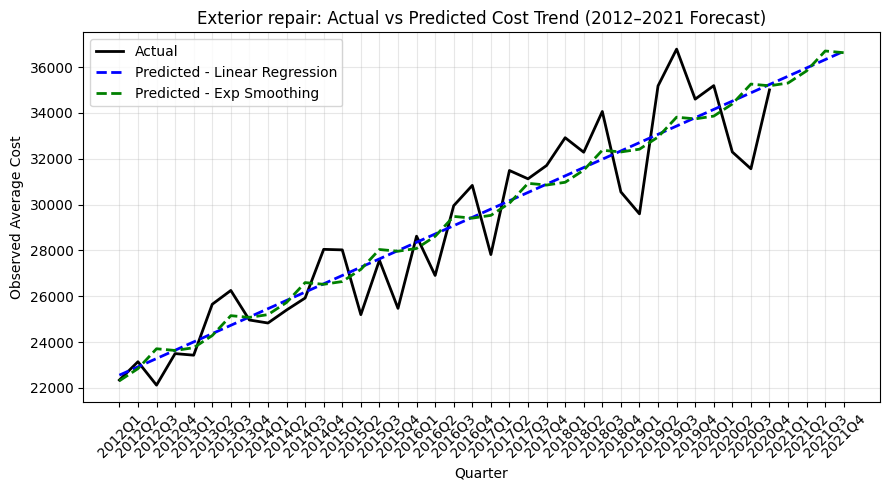

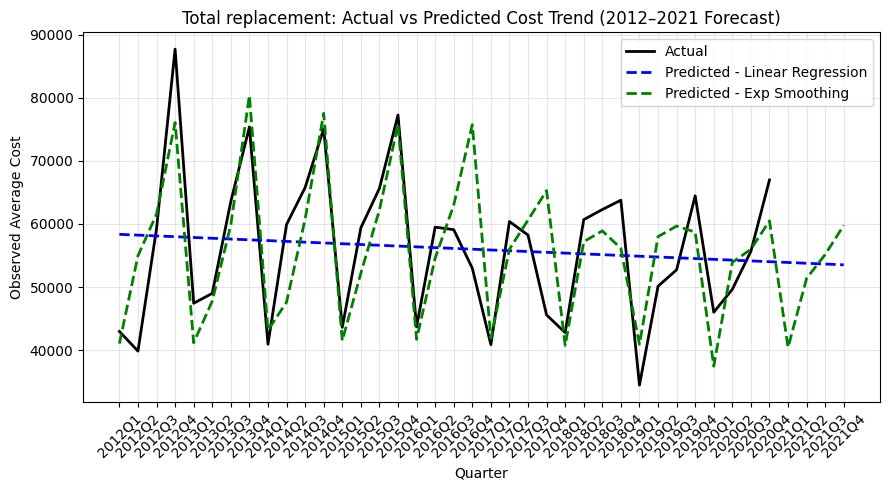

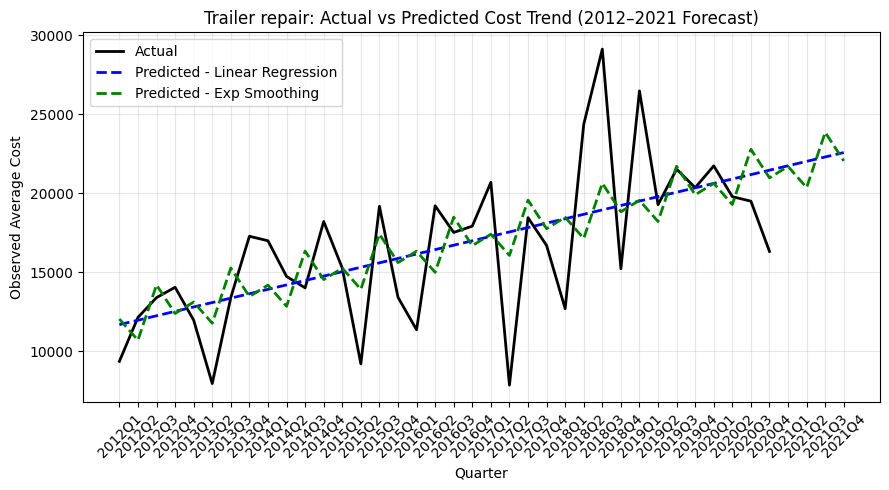

,repair_type,year,quarter,year_quarter,Actual,Pred_LR,Pred_ES,RMSE_LR,MAE_LR,MAPE_LR,RMSE_ES,MAE_ES,MAPE_ES
0,Exterior repair,2012,1,2012Q1,22344.3100,22559.014835,22312.531984,214.704835,214.704835,0.960893,31.778016,31.778016,0.142220
1,Exterior repair,2012,2,2012Q2,23143.7600,22921.287447,22842.368089,222.472553,222.472553,0.961264,301.391911,301.391911,1.302260
2,Exterior repair,2012,3,2012Q3,22123.2800,23283.560060,23709.951514,1160.280060,1160.280060,5.244611,1586.671514,1586.671514,7.171954
3,Exterior repair,2012,4,2012Q4,23498.9800,23645.832673,23635.314709,146.852673,146.852673,0.624932,136.334709,136.334709,0.580173
4,Exterior repair,2013,1,2013Q1,23430.0500,24008.105285,23755.960729,578.055285,578.055285,2.467153,325.910729,325.910729,1.390995
5,Exterior repair,2013,2,2013Q2,25651.1800,24370.377898,24285.796829,1280.802102,1280.802102,4.993151,1365.383171,1365.383171,5.322886
6,Exterior repair,2013,3,2013Q3,26253.0200,24732.650511,25153.380270,1520.369489,1520.369489,5.791218,1099.639730,1099.639730,4.188622
7,Exterior repair,2013,4,2013Q4,24964.6000,25094.923123,25078.743505,130.323123,130.323123,0.522032,114.143505,114.143505,0.457221
8,Exterior repair,2014,1,2014Q1,24833.3600,25457.195736,25199.389525,623.835736,623.835736,2.512088,366.029525,366.029525,1.473943
9,Exterior repair,2014,2,2014Q2,25399.5700,25819.468348,25729.225624,419.898348,419.898348,1.653171,329.655624,329.655624,1.297879


In [19]:
def run_models_all_years(df, repair_type):
    df = df[df['repair_type'] == repair_type].copy().reset_index(drop=True)
    df['time_index'] = np.arange(1, len(df) + 1)

    # 1️⃣ Linear Regression
    lr = LinearRegression()
    lr.fit(df[['time_index']], df['observed_average_cost'])
    df['pred_lr'] = lr.predict(df[['time_index']])

    # 2️⃣ Exponential Smoothing
    es = ExponentialSmoothing(df['observed_average_cost'],
                              trend='add', seasonal='add', seasonal_periods=4).fit()
    df['pred_es'] = es.predict(start=0, end=len(df)-1)

    # 3️⃣ Forecast 2021 (no actuals)
    future_idx = np.arange(df['time_index'].max() + 1, df['time_index'].max() + 5)
    forecast_lr = lr.predict(future_idx.reshape(-1, 1))
    forecast_es = es.forecast(4)

    df_forecast = pd.DataFrame({
        'year': [2021]*4,
        'quarter': [1,2,3,4],
        'repair_type': repair_type,
        'pred_lr': forecast_lr,
        'pred_es': forecast_es
    })
    df_forecast['year_quarter'] = df_forecast['year'].astype(str) + 'Q' + df_forecast['quarter'].astype(str)
    df_forecast['observed_average_cost'] = np.nan

    # Combine all (2012–2021)
    df_all = pd.concat([df, df_forecast], ignore_index=True)

    # --- Compute quarterly metrics ---
    df_all_metrics = []
    for (y, q), g in df_all.groupby(['year', 'quarter']):
        if g['observed_average_cost'].notna().all():
            rmse_lr, mae_lr, mape_lr = compute_metrics(g['observed_average_cost'], g['pred_lr'])
            rmse_es, mae_es, mape_es = compute_metrics(g['observed_average_cost'], g['pred_es'])
        else:
            rmse_lr = mae_lr = mape_lr = rmse_es = mae_es = mape_es = np.nan
        df_all_metrics.append({
            'repair_type': repair_type,
            'year': y,
            'quarter': q,
            'year_quarter': f"{y}Q{q}",
            'Actual': g['observed_average_cost'].mean(),
            'Pred_LR': g['pred_lr'].mean(),
            'Pred_ES': g['pred_es'].mean(),
            'RMSE_LR': rmse_lr,
            'MAE_LR': mae_lr,
            'MAPE_LR': mape_lr,
            'RMSE_ES': rmse_es,
            'MAE_ES': mae_es,
            'MAPE_ES': mape_es
        })
    df_all_metrics = pd.DataFrame(df_all_metrics)

    # --- 🔹 NEW: Compute yearly metrics (aggregating all 4 quarters) ---
    df_yearly = (
        df_all.groupby('year', as_index=False)
        .agg({
            'observed_average_cost': 'mean',
            'pred_lr': 'mean',
            'pred_es': 'mean'
        })
        .rename(columns={
            'observed_average_cost': 'Actual',
            'pred_lr': 'Pred_LR',
            'pred_es': 'Pred_ES'
        })
    )

    # Compute metrics for years with actuals
    yearly_metrics = []
    for _, g in df_yearly.iterrows():
        if not np.isnan(g['Actual']):
            # Convert to NumPy arrays for safe math
            y_true = np.array([g['Actual']])
            y_pred_lr = np.array([g['Pred_LR']])
            y_pred_es = np.array([g['Pred_ES']])

            rmse_lr, mae_lr, mape_lr = compute_metrics(y_true, y_pred_lr)
            rmse_es, mae_es, mape_es = compute_metrics(y_true, y_pred_es)
        else:
            rmse_lr = mae_lr = mape_lr = rmse_es = mae_es = mape_es = np.nan

        yearly_metrics.append({
            'repair_type': repair_type,
            'year': int(g['year']),
            'quarter': 'All',
            'year_quarter': f"{int(g['year'])}_All",
            'Actual': g['Actual'],
            'Pred_LR': g['Pred_LR'],
            'Pred_ES': g['Pred_ES'],
            'RMSE_LR': rmse_lr,
            'MAE_LR': mae_lr,
            'MAPE_LR': mape_lr,
            'RMSE_ES': rmse_es,
            'MAE_ES': mae_es,
            'MAPE_ES': mape_es
        })


    df_yearly_metrics = pd.DataFrame(yearly_metrics)

    # Combine quarterly + yearly metrics
    df_all_metrics = pd.concat([df_all_metrics, df_yearly_metrics], ignore_index=True)

    # --- Plotting ---
    plt.figure(figsize=(9, 5))
    plt.plot(df_all['year_quarter'], df_all['observed_average_cost'], color='black', label='Actual', linewidth=2)
    plt.plot(df_all['year_quarter'], df_all['pred_lr'], '--', color='blue', label='Predicted - Linear Regression', linewidth=2)
    plt.plot(df_all['year_quarter'], df_all['pred_es'], '--', color='green', label='Predicted - Exp Smoothing', linewidth=2)
    plt.title(f"{repair_type}: Actual vs Predicted Cost Trend (2012–2021 Forecast)")
    plt.xlabel("Quarter")
    plt.ylabel("Observed Average Cost")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_all_metrics

all_metrics = []
for rep in ['Exterior repair', 'Total replacement', 'Trailer repair']:
    m = run_models_all_years(data2, rep)
    all_metrics.append(m)

metrics_all = pd.concat(all_metrics).reset_index(drop=True)
metrics_all

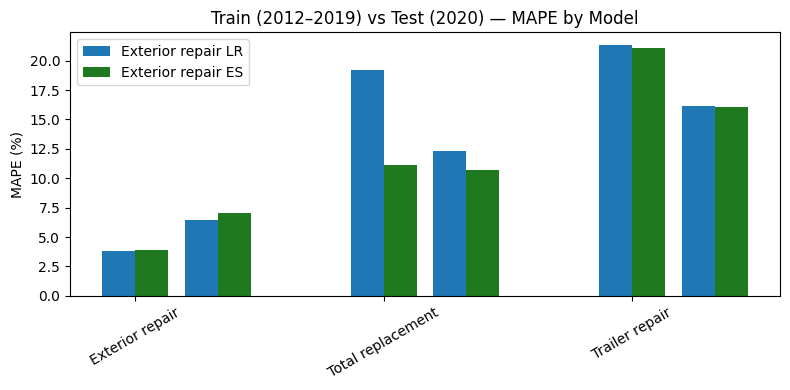

In [ ]:
# --- Evaluate models on Train (2012–2019) and Test (2020) ---
def compute_metrics(y_true, y_pred): # expects 1D numpy arrays or lists 
    y_true = np.array(y_true, dtype=float) 
    y_pred = np.array(y_pred, dtype=float) 
    rmse = sqrt(mean_squared_error(y_true, y_pred)) 
    mae = mean_absolute_error(y_true, y_pred) 
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan 
    return rmse, mae, mape

train_test_metrics = []

df = data2.copy()

repair_types = df['repair_type'].unique()

for repair in repair_types:
    dfr = df[df['repair_type'] == repair].copy().reset_index(drop=True)
    dfr['time_index'] = np.arange(1, len(dfr) + 1)
    
    # Split
    train_df = dfr[dfr['year'] < 2020]
    test_df = dfr[dfr['year'] == 2020]
    
    # --- Linear Regression ---
    lr = LinearRegression()
    lr.fit(train_df[['time_index']], train_df['observed_average_cost'])
    
    # Predictions
    train_pred_lr = lr.predict(train_df[['time_index']])
    test_pred_lr = lr.predict(test_df[['time_index']])
    
    # --- Exponential Smoothing ---
    es_train = ExponentialSmoothing(train_df['observed_average_cost'],
                                    trend='add', seasonal='add', seasonal_periods=4).fit()
    train_pred_es = es_train.fittedvalues
    test_pred_es = es_train.forecast(len(test_df))
    
    # --- Compute metrics ---
    rmse_lr_tr, mae_lr_tr, mape_lr_tr = compute_metrics(train_df['observed_average_cost'], train_pred_lr)
    rmse_lr_ts, mae_lr_ts, mape_lr_ts = compute_metrics(test_df['observed_average_cost'], test_pred_lr)
    rmse_es_tr, mae_es_tr, mape_es_tr = compute_metrics(train_df['observed_average_cost'], train_pred_es)
    rmse_es_ts, mae_es_ts, mape_es_ts = compute_metrics(test_df['observed_average_cost'], test_pred_es)
    
    train_test_metrics.append({
        'repair_type': repair,
        'set': 'Train (2012–2019)',
        'RMSE_LR': rmse_lr_tr, 'MAE_LR': mae_lr_tr, 'MAPE_LR': mape_lr_tr,
        'RMSE_ES': rmse_es_tr, 'MAE_ES': mae_es_tr, 'MAPE_ES': mape_es_tr
    })
    train_test_metrics.append({
        'repair_type': repair,
        'set': 'Test (2020)',
        'RMSE_LR': rmse_lr_ts, 'MAE_LR': mae_lr_ts, 'MAPE_LR': mape_lr_ts,
        'RMSE_ES': rmse_es_ts, 'MAE_ES': mae_es_ts, 'MAPE_ES': mape_es_ts
    })

train_test_df = pd.DataFrame(train_test_metrics)
# train_test_df.to_csv(os.path.join(OUT_DIR, 'train_test_metrics_by_model.csv'), index=False)

# print("Saved: train_test_metrics_by_model.csv")

# --- Optional: Bar Chart comparing MAPE ---
plt.figure(figsize=(8,4))
for i, repair in enumerate(repair_types):
    temp = train_test_df[train_test_df['repair_type'] == repair]
    x = np.arange(2) + i*3
    plt.bar(x - 0.2, temp['MAPE_LR'], width=0.4, label=f"{repair} LR" if i == 0 else "", color='#1f77b4')
    plt.bar(x + 0.2, temp['MAPE_ES'], width=0.4, label=f"{repair} ES" if i == 0 else "", color='#1f7a1f')

plt.xticks(np.arange(0, len(repair_types)*3, 3), repair_types, rotation=30)
plt.ylabel('MAPE (%)')
plt.title('Train (2012–2019) vs Test (2020) — MAPE by Model')
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(OUT_DIR, 'train_test_summary_bar.png'), dpi=200)
# plt.close()
# print("Saved: train_test_summary_bar.png")


In [ ]:
train_test_df

,repair_type,set,RMSE_LR,MAE_LR,MAPE_LR,RMSE_ES,MAE_ES,MAPE_ES
0,Exterior repair,Train (2012–2019),1442.261417,1096.686064,3.829251,1388.727901,1112.742186,3.929948
1,Exterior repair,Test (2020),2558.156437,2088.569655,6.456646,2815.922306,2283.057458,7.058443
2,Total replacement,Train (2012–2019),12219.815089,10136.858281,19.227407,7808.757881,5969.729052,11.139083
3,Total replacement,Test (2020),8153.555242,6900.524063,12.356264,6998.130585,5774.744342,10.691365
4,Trailer repair,Train (2012–2019),3934.842519,2938.407824,21.344533,3714.642403,3018.265255,21.049946
5,Trailer repair,Test (2020),3615.845705,2843.840477,16.116272,3817.879557,2845.581816,16.061104
